#📌 Introduction


In the era of high-resolution satellite imagery and autonomous aerial vehicles, accurately aligning drone-captured frames with pre-existing satellite maps is crucial for tasks such as geospatial mapping, object tracking, and navigation. This project leverages SuperPoint for feature extraction and SuperGlue for feature matching, enabling precise alignment of aerial drone images with satellite tiles.

The pipeline follows a structured approach:


1.   Feature Extraction – SuperPoint detects keypoints and extracts descriptors.

2.   Feature Matching – SuperGlue matches corresponding keypoints between frames and tiles.
3.   GPS Estimation – The best-matched tile's GPS coordinates are used to estimate the drone's position.









By integrating these deep learning-based models, we achieve robust and efficient feature matching, significantly enhancing the accuracy of aerial image localization.



#1: Import Requirements

##1.1 Import Libraries

In [1]:
import os
import cv2
import torch
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch import nn
from tqdm import tqdm
from pathlib import Path
from copy import deepcopy
from typing import List, Tuple
from torchvision import transforms

##1.2 Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##1.3 Define File Paths

In [3]:
# Define paths for the drone video and satellite tiles dataset
VIDEO_PATH = '/content/drive/My Drive/drone_video.mp4'  # Path to the input drone video file
TILES_PATH = '/content/drive/My Drive/gps_tiles.zip'  # Path to the compressed satellite tiles dataset

# Define directories for extracted satellite tiles and video frames
extract_to_dir = '/content/tiles'  # Directory where satellite tiles will be extracted
output_folder = '/content/capframes'  # Directory to store extracted video frames

In [4]:
# Ensure the output directory for video frames exists
os.makedirs(output_folder, exist_ok=True)

#2: Extract Frames from Drone Video

##2.1 Open Video File

In [5]:
# Open the drone video file for processing
cap = cv2.VideoCapture(VIDEO_PATH)

# Print the total number of frames in the video
print(f"Total frames in video: {cap.get(cv2.CAP_PROP_FRAME_COUNT)}")

Total frames in video: 1866.0


##2.2 Extract Frames at One-Second Intervals

In [6]:
# Check if the video file was successfully opened
if not cap.isOpened():
    print("Error: Could not open video file!")  # Display error if the video cannot be loaded
else:
    # Get the video's frames per second (FPS)
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Define the frame extraction rate (every second)
    frame_rate = 1  # Capture one frame per second
    frame_interval = fps * frame_rate  # Interval at which frames will be saved

    count = 0  # Frame counter
    frame_index = 0  # Index for saved frames

    # Read frames from the video
    while True:
        ret, frame = cap.read()  # Read the next frame
        if not ret:
            break  # Stop if the video ends

        # Save the frame at the specified interval
        if count % frame_interval == 0:
            frame_filename = os.path.join(output_folder, f"frame_{frame_index}.jpg")
            cv2.imwrite(frame_filename, frame)  # Save the extracted frame
            frame_index += 1  # Increment saved frame index

        count += 1  # Increment total frame counter

    # Release the video capture object after processing
    cap.release()

    # Print the total number of frames extracted
    print("Total frames extracted:", frame_index)

Total frames extracted: 63


##2.3 Display Sample Extracted Frames

In [7]:
# Display the first five extracted frames to verify successful extraction
print(os.listdir(output_folder)[:5])

['frame_62.jpg', 'frame_51.jpg', 'frame_58.jpg', 'frame_33.jpg', 'frame_4.jpg']


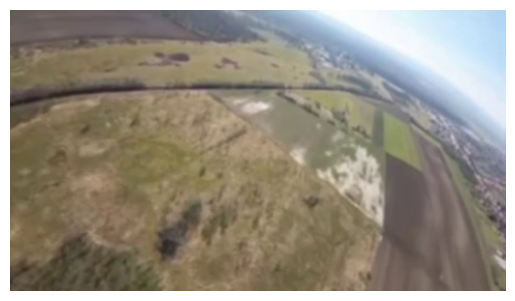

In [8]:
# Select a sample frame (frame_25) to visualize
sample_frame_path = os.path.join(output_folder, "frame_25.jpg")

# Check if the selected frame exists
if os.path.exists(sample_frame_path):
    # Load the frame image
    frame = cv2.imread(sample_frame_path)

    # Convert BGR (OpenCV default) to RGB for correct color display in Matplotlib
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display the frame
    plt.imshow(frame)
    plt.axis("off")  # Hide axes for a cleaner view
    plt.show()
else:
    print("No frame found!")  # Handle the case where the frame doesn't exist

#3: Extract and Load Satellite Tiles

##3.1 Extract Satellite Tiles from ZIP File

In [9]:
# Extract the satellite tiles dataset from the ZIP file
with zipfile.ZipFile(TILES_PATH, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)  # Extract all contents to the specified directory

# List the extracted files to verify successful extraction
extracted_contents = os.listdir(extract_to_dir)
print(f"Contents of '{extract_to_dir}': {extracted_contents}")

Contents of '/content/tiles': ['azure_csv']


##3.2 Load Satellite Tile Images

In [10]:
# Define the directory containing extracted satellite tiles
sat_tiles_dir = "/content/tiles/azure_csv"

# Get a sorted list of all files in the satellite tiles directory
tile_files = sorted(os.listdir(sat_tiles_dir))

# Filter the list to include only PNG files (satellite images)
tile_files = [f for f in tile_files if f.endswith('.png')]

# Display the first five satellite tile filenames to verify loading
print("First 5 satellite tiles:", tile_files[:5])

First 5 satellite tiles: ['sat_map_00.png', 'sat_map_01.png', 'sat_map_02.png', 'sat_map_03.png', 'sat_map_04.png']


#3.3 Display a Sample Satellite Tile

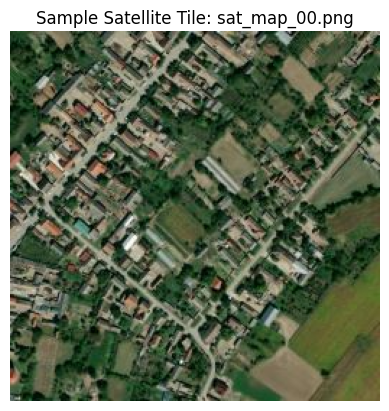

In [11]:
# Check if any satellite tiles were found
if len(tile_files) == 0:
    print("Error: No satellite tiles found!")  # Handle the case where no tiles are available
else:
    # Select the first satellite tile as a sample
    sample_tile_path = os.path.join(sat_tiles_dir, tile_files[0])

    # Load the satellite tile image
    tile = cv2.imread(sample_tile_path)

    # Ensure the image was successfully loaded
    if tile is not None:
        # Convert BGR (OpenCV default) to RGB for correct color display in Matplotlib
        tile = cv2.cvtColor(tile, cv2.COLOR_BGR2RGB)

        # Display the satellite tile
        plt.imshow(tile)
        plt.axis("off")  # Hide axes for a cleaner view
        plt.title(f"Sample Satellite Tile: {tile_files[0]}")  # Set title for clarity
        plt.show()
    else:
        print(f"Error: Could not load {sample_tile_path}")  # Handle loading error

#4: Preprocessing Images

##4.1 Define Input and Output Paths for Preprocessed Data

In [12]:
# Define paths for raw frames and satellite tiles
frames_folder = "/content/capframes"  # Folder containing extracted frames from the video
tiles_folder = "/content/tiles/azure_csv"  # Folder containing extracted satellite tiles

# Define directories for storing preprocessed images
processed_frames_folder = "/content/processed_frames"  # Folder for processed drone frames
processed_tiles_folder = "/content/processed_tiles"  # Folder for processed satellite tiles

In [13]:
# Ensure the processed directories exist (create them if they don’t)
os.makedirs(processed_frames_folder, exist_ok=True)
os.makedirs(processed_tiles_folder, exist_ok=True)

##4.2 Define Image Preprocessing Function

In [14]:
def preprocess_image(image_path):
    """
    Preprocesses an image by applying grayscale conversion, contrast enhancement (CLAHE),
    sharpening, normalization, resizing, and converting to a PyTorch tensor.

    Parameters:
        image_path (str): Path to the input image.

    Returns:
        tensor_image (torch.Tensor): Preprocessed image as a PyTorch tensor.
    """

    # Load the image from the given path
    image = cv2.imread(image_path)

    # Handle case where image loading fails
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")

    # Convert to grayscale if the image has 3 channels (color)
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image  # Already grayscale

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    # Apply sharpening filter to enhance details
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    gray = cv2.filter2D(gray, -1, kernel)

    # Normalize pixel values to range [0, 1]
    gray = gray.astype("float32") / 255.0

    # Resize the image to (640, 480) for consistency in processing
    gray_resized = cv2.resize(gray, (640, 480))

    # Convert the processed image to a PyTorch tensor and add a batch dimension
    tensor_image = torch.from_numpy(gray_resized).unsqueeze(0)

    return tensor_image

##4.3 Process and Save Preprocessed Frames

In [15]:
# Get a sorted list of all extracted frame filenames
frame_files = sorted(os.listdir(frames_folder))

# Process each frame and save the preprocessed version
for file in tqdm(frame_files, desc="Processing Frames"):
    frame_path = os.path.join(frames_folder, file)  # Full path to the frame image

    # Apply preprocessing to the frame
    processed_frame = preprocess_image(frame_path)

    # Save the processed frame as a PyTorch tensor file (.pt)
    torch.save(processed_frame, os.path.join(processed_frames_folder, file.replace(".jpg", ".pt")))

Processing Frames: 100%|██████████| 63/63 [00:00<00:00, 163.67it/s]


##4.4 Process and Save Preprocessed Satellite Tiles

In [16]:
# Get a sorted list of all satellite tile filenames
tile_files = sorted(os.listdir(tiles_folder))

# Define valid image file extensions
valid_extensions = ('.png', '.jpg', '.jpeg')

# Filter only valid image files
tile_files = [f for f in os.listdir(tiles_folder) if f.lower().endswith(valid_extensions)]

# Process each satellite tile and save the preprocessed version
for file in tqdm(tile_files, desc="Processing Tiles"):
    tile_path = os.path.join(tiles_folder, file)  # Full path to the satellite tile image

    # Apply preprocessing to the tile
    processed_tile = preprocess_image(tile_path)

    # Check if preprocessing was successful
    if processed_tile is None:
        print(f"Warning: Invalid image {file}")  # Handle cases where an image fails to process
        continue  # Skip this image and continue with the next one

    # Save the processed tile as a PyTorch tensor file (.pt)
    torch.save(processed_tile, os.path.join(processed_tiles_folder, file.replace(".png", ".pt")))

Processing Tiles: 100%|██████████| 48/48 [00:00<00:00, 204.61it/s]


#5: Verification & Visualization

##5.1 Load Sample Preprocessed Data

In [17]:
# Define paths to a sample processed frame and satellite tile for verification
test_frame_path = "/content/processed_frames/frame_10.pt"
test_tile_path = "/content/processed_tiles/sat_map_15.pt"

try:
    # Load the preprocessed frame tensor
    test_frame = torch.load(test_frame_path)

    # Load the preprocessed satellite tile tensor
    test_tile = torch.load(test_tile_path)

    # Confirm successful loading and display tensor shapes
    print("Successfully loaded processed frame and tile tensors.")
    print(f"Frame shape: {test_frame.shape},\nTile shape: {test_tile.shape}")

except Exception as e:
    print(f"Error loading processed images: {e}")  # Handle loading errors gracefully

Successfully loaded processed frame and tile tensors.
Frame shape: torch.Size([1, 480, 640]),
Tile shape: torch.Size([1, 480, 640])


##5.2 Define Visualization Function

In [18]:
def visualize_preprocessing(frame_path, tile_path):
    """
    Visualizes the preprocessing results for a given frame and satellite tile.

    Parameters:
        frame_path (str): Path to the processed frame tensor (.pt file).
        tile_path (str): Path to the processed satellite tile tensor (.pt file).

    Returns:
        None (Displays the images)
    """
    try:
        # Load the processed frame and convert it back to a NumPy array
        frame_tensor = torch.load(frame_path).squeeze(0).numpy()

        # Load the processed satellite tile and convert it back to a NumPy array
        tile_tensor = torch.load(tile_path).squeeze(0).numpy()

        # Set up a side-by-side visualization
        plt.figure(figsize=(10, 5))

        # Display the processed frame
        plt.subplot(1, 2, 1)
        plt.imshow(frame_tensor, cmap="gray")
        plt.title(f"Processed Frame: {frame_path.split('/')[-1]}")
        plt.axis("off")  # Hide axes for clarity

        # Display the processed satellite tile
        plt.subplot(1, 2, 2)
        plt.imshow(tile_tensor, cmap="gray")
        plt.title(f"Processed Tile: {tile_path.split('/')[-1]}")
        plt.axis("off")  # Hide axes for clarity

        # Show the visualization
        plt.show()

    except Exception as e:
        print(f"Error loading tensors: {e}")  # Handle errors gracefully

##5.3 Visualize Sample Processed Frame & Satellite Tile

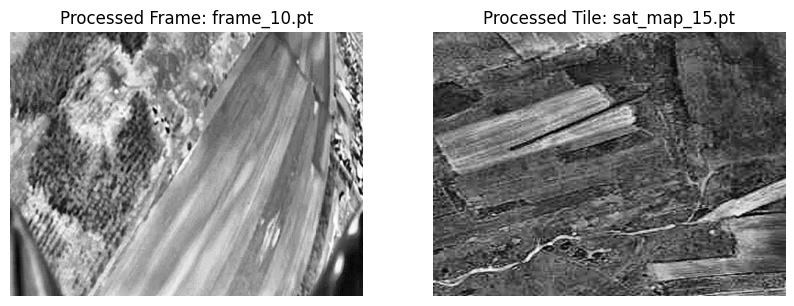

In [19]:
# Visualize the preprocessing results for a selected frame and satellite tile
visualize_preprocessing("/content/processed_frames/frame_10.pt",
                        "/content/processed_tiles/sat_map_15.pt")

#6: Feature Extraction and Keypoint Detection

##6.1 Implementing Non-Maximum Suppression (NMS)

In [20]:
def simple_nms(scores, nms_radius: int):
    """
    Applies Non-Maximum Suppression (NMS) to suppress non-peak keypoint scores.

    Parameters:
        scores (torch.Tensor): The input score map (e.g., from a feature detector).
        nms_radius (int): The radius around each keypoint where non-maximum values will be suppressed.

    Returns:
        torch.Tensor: A score map where only local maxima are retained.
    """
    assert(nms_radius >= 0), "NMS radius must be non-negative."

    def max_pool(x):
        """
        Applies max pooling to find local maxima in the score map.
        Uses a kernel size of (2 * nms_radius + 1) to define the suppression region.
        """
        return torch.nn.functional.max_pool2d(
            x, kernel_size=nms_radius * 2 + 1, stride=1, padding=nms_radius)

    # Create a zero tensor with the same shape as scores (to suppress non-maxima)
    zeros = torch.zeros_like(scores)

    # Identify local maxima by comparing with the max-pooled version of the scores
    max_mask = scores == max_pool(scores)

    # Perform two iterations of suppression to refine the mask
    for _ in range(2):
        # Expand the suppression region by applying max pooling on the mask
        supp_mask = max_pool(max_mask.float()) > 0

        # Suppress scores in the identified suppression region
        supp_scores = torch.where(supp_mask, zeros, scores)

        # Recalculate the max mask based on the updated scores
        new_max_mask = supp_scores == max_pool(supp_scores)

        # Combine the new maxima with the previous ones while avoiding suppression artifacts
        max_mask = max_mask | (new_max_mask & (~supp_mask))

    # Retain only the maximum values, setting all others to zero
    return torch.where(max_mask, scores, zeros)

##6.2 Filtering and Selecting Keypoints


In [21]:
def remove_borders(keypoints, scores, border: int, height: int, width: int):
    """
    Removes keypoints that are too close to the image border.

    Parameters:
        keypoints (torch.Tensor): Tensor of shape (N, 2) containing (y, x) coordinates of keypoints.
        scores (torch.Tensor): Tensor of shape (N,) containing scores for each keypoint.
        border (int): The minimum allowed distance from the image border.
        height (int): The height of the image.
        width (int): The width of the image.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Filtered keypoints and their corresponding scores.
    """
    # Create masks to filter out keypoints too close to the top/bottom border
    mask_h = (keypoints[:, 0] >= border) & (keypoints[:, 0] < (height - border))

    # Create masks to filter out keypoints too close to the left/right border
    mask_w = (keypoints[:, 1] >= border) & (keypoints[:, 1] < (width - border))

    # Combine both masks to get keypoints within valid image boundaries
    mask = mask_h & mask_w

    # Apply the mask to filter keypoints and their scores
    return keypoints[mask], scores[mask]

In [22]:
def top_k_keypoints(keypoints, scores, k: int):
    """
    Selects the top-k keypoints based on their scores.

    Parameters:
        keypoints (torch.Tensor): Tensor of shape (N, 2) containing (y, x) coordinates of keypoints.
        scores (torch.Tensor): Tensor of shape (N,) containing scores for each keypoint.
        k (int): The number of top keypoints to retain.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: The top-k keypoints and their corresponding scores.
    """
    # If k is greater than or equal to the total number of keypoints, return all keypoints
    if k >= len(keypoints):
        return keypoints, scores

    # Select the indices of the top-k scores
    scores, indices = torch.topk(scores, k, dim=0)

    # Return the top-k keypoints and their corresponding scores
    return keypoints[indices], scores

In [23]:
def sample_descriptors(keypoints, descriptors, s: int = 8):
    """
    Samples local descriptors at given keypoint locations using bilinear interpolation.

    Parameters:
        keypoints (torch.Tensor): Tensor of shape (N, 2) containing (y, x) coordinates of keypoints.
        descriptors (torch.Tensor): Tensor of shape (B, C, H, W) representing feature descriptors.
        s (int, optional): Scaling factor for normalizing keypoint coordinates. Default is 8.

    Returns:
        torch.Tensor: Sampled descriptors of shape (B, C, N).
    """
    # Get descriptor tensor dimensions: batch (B), channels (C), height (H), width (W)
    b, c, h, w = descriptors.shape

    # Normalize keypoints to the range [-1, 1] for grid sampling
    keypoints = keypoints - s / 2 + 0.5  # Adjust keypoints based on the scaling factor
    keypoints /= torch.tensor([(w * s - s / 2 - 0.5), (h * s - s / 2 - 0.5)]
                              ).to(keypoints)[None]  # Normalize to image dimensions
    keypoints = keypoints * 2 - 1  # Convert to range [-1, 1] for grid_sample

    # Adjust align_corners parameter for compatibility with different PyTorch versions
    args = {'align_corners': True} if torch.__version__ >= '1.3' else {}

    # Sample descriptors using bilinear interpolation
    descriptors = torch.nn.functional.grid_sample(
        descriptors, keypoints.view(b, 1, -1, 2), mode='bilinear', **args)

    # Normalize descriptors to unit length using L2 normalization
    descriptors = torch.nn.functional.normalize(
        descriptors.reshape(b, c, -1), p=2, dim=1)

    return descriptors

##6.3 Defining the SuperPoint Model


In [24]:
class SuperPoint(nn.Module):
    """
    SuperPoint feature extractor for keypoint detection and description.

    Attributes:
        default_config (dict): Default configuration for model parameters.
        relu (nn.ReLU): ReLU activation function.
        pool (nn.MaxPool2d): Max pooling layer for downsampling.
        conv layers (nn.Conv2d): Convolutional layers for feature extraction.
    """

    default_config = {
        'descriptor_dim': 256,  # Dimension of feature descriptors
        'nms_radius': 2,  # Non-maximum suppression radius
        'keypoint_threshold': 0.0035,  # Threshold for detecting keypoints
        'max_keypoints': 1000,  # Maximum number of keypoints (-1 for no limit)
        'remove_borders': 4,  # Pixels to ignore near image borders
    }

    def __init__(self, config={}):
        super().__init__()
        self.config = {**self.default_config, **config}

        # Define activation and pooling layers
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional feature extractor layers
        c1, c2, c3, c4, c5 = 64, 64, 128, 128, 256

        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)

        # Keypoint detection layers
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)

        # Descriptor generation layers
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(
            c5, self.config['descriptor_dim'], kernel_size=1, stride=1, padding=0
        )

        # Load pre-trained model weights
        path = Path('/content/drive/MyDrive/superpoint_v1.pth')
        self.load_state_dict(torch.load(str(path)))

        # Validate max_keypoints parameter
        if self.config['max_keypoints'] == 0 or self.config['max_keypoints'] < -1:
            raise ValueError('"max_keypoints" must be positive or "-1"')

        print('Loaded SuperPoint model')

    def forward(self, data):
        """
        Forward pass for SuperPoint network.

        Parameters:
            data (dict): Input dictionary containing 'image' key with a tensor.

        Returns:
            dict: Dictionary containing 'keypoints', 'scores', and 'descriptors'.
        """
        # Extract shared feature representation
        x = self.relu(self.conv1a(data['image']))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))

        # Keypoint detection branch
        cPa = self.relu(self.convPa(x))
        scores = self.convPb(cPa)  # Raw keypoint scores
        scores = torch.nn.functional.softmax(scores, 1)[:, :-1]  # Normalize scores
        b, _, h, w = scores.shape

        # Reshape scores to match keypoint map dimensions
        scores = scores.permute(0, 2, 3, 1).reshape(b, h, w, 8, 8)
        scores = scores.permute(0, 1, 3, 2, 4).reshape(b, h * 8, w * 8)

        # Apply non-maximum suppression (NMS)
        scores = simple_nms(scores, self.config['nms_radius'])

        # Extract keypoints based on threshold
        keypoints = [torch.nonzero(s > self.config['keypoint_threshold']) for s in scores]
        scores = [s[tuple(k.t())] for s, k in zip(scores, keypoints)]

        # Filter out weak keypoints based on score distribution
        strong_keypoints = []
        strong_scores = []

        for k, s in zip(keypoints, scores):
            mean_score = s.mean()
            filtered_mask = s > (mean_score * 0.8)  # Retain only strong keypoints
            strong_keypoints.append(k[filtered_mask])
            strong_scores.append(s[filtered_mask])

        keypoints = strong_keypoints
        scores = strong_scores

        # Remove keypoints near image borders
        keypoints, scores = zip(*[
            remove_borders(k, s, self.config['remove_borders'], h * 8, w * 8)
            for k, s in zip(keypoints, scores)
        ])

        # Retain only top-k keypoints if needed
        if self.config['max_keypoints'] >= 0:
            keypoints, scores = zip(*[
                top_k_keypoints(k, s, self.config['max_keypoints'])
                for k, s in zip(keypoints, scores)
            ])

        # Convert keypoints to (x, y) format
        keypoints = [torch.flip(k, [1]).float() for k in keypoints]

        # Descriptor extraction branch
        cDa = self.relu(self.convDa(x))
        descriptors = self.convDb(cDa)
        descriptors = torch.nn.functional.normalize(descriptors, p=2, dim=1)

        # Sample descriptors at keypoint locations
        descriptors = [
            sample_descriptors(k[None], d[None], 8)[0]
            for k, d in zip(keypoints, descriptors)
        ]

        return {
            'keypoints': keypoints,
            'scores': scores,
            'descriptors': descriptors,
        }

In [25]:
# Check if a GPU is available; otherwise, default to using the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the SuperPoint model and move it to the chosen device (GPU or CPU)
superpoint = SuperPoint().to(device)

# Set the model to evaluation mode (disables training-specific layers like dropout)
superpoint.eval()

Loaded SuperPoint model


SuperPoint(
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPb): Conv2d(256, 65, kernel_size=(1, 1), stride=(1, 1))
  (convDa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convDb): Conv2d(25

##6.4 Extracting Features from Images

###6.4.1 Function Load Images

In [26]:
def load_image(img_path):
    """
    Load a preprocessed image tensor from a .pt file.

    Args:
        img_path (str): Path to the preprocessed image file.

    Returns:
        torch.Tensor: Loaded image tensor.

    Raises:
        ValueError: If the file is not a .pt file or cannot be loaded.
    """

    # Ensure the file is a .pt tensor file
    if img_path.endswith(".pt"):
        img = torch.load(img_path)

        # Check if loading was successful
        if img is None:
            raise ValueError(f"Error loading tensor: {img_path}")

        # If the tensor has 3 dimensions, add a batch dimension
        if len(img.shape) == 3:
            img = img.unsqueeze(0)

        return img

    else:
        raise ValueError(f"Unexpected file type: {img_path} (Expected .pt)")

###6.4.2 Function Extract Features

In [27]:
def extract_features(image_path):
    try:
        # Load and move the image tensor to the appropriate device (CPU/GPU)
        image = load_image(image_path).to(device)

        # Ensure no gradients are computed for inference (optimization for speed & memory)
        with torch.no_grad():
            output = superpoint({'image': image})  # Run SuperPoint model on the image

        # Extract keypoints, descriptors, and scores from the model output
        keypoints = output['keypoints'][0].to(device)
        descriptors = output['descriptors'][0].to(device)
        scores = output['scores'][0].to(device)

        # Handle cases where no keypoints are detected
        if keypoints is None or len(keypoints) == 0:
            print(f"Warning: No keypoints detected in {image_path}")
            return None, None, None

        # Ensure descriptors have the correct shape (transpose if necessary)
        if descriptors.shape[0] == 256:
            descriptors = descriptors.T  # Convert from (256, N) to (N, 256)

        return keypoints, descriptors, scores
    except Exception as e:
        # Handle any errors that occur during feature extraction
        print(f"Error extracting features from {image_path}: {e}")
        return None, None, None

## 6.5 Processing Frames and Satellite Tiles


### 6.5.1 Define Processed directories



In [28]:
# Define directories for processed frames, processed tiles, and extracted features
processed_frames_folder = "/content/processed_frames"
processed_tiles_folder = "/content/processed_tiles"
features_folder = "/content/extracted_features"

In [29]:
# Ensure the directory for extracted features exists, create it if necessary
os.makedirs(features_folder, exist_ok=True)

### 6.5.2 Processing Frames


In [30]:
# Iterate through all processed frames to extract features
for frame_file in tqdm(sorted(os.listdir(processed_frames_folder)), desc="Extracting Frame Features"):
    # Ensure the file is a PyTorch tensor file before processing
    if not frame_file.endswith('.pt'):
        continue

    # Construct the full path to the frame file
    frame_path = os.path.join(processed_frames_folder, frame_file)

    # Extract keypoints, descriptors, and scores using the SuperPoint model
    keypoints, descriptors, scores = extract_features(frame_path)

    # Save extracted features only if keypoints were detected
    if keypoints is not None:
        feature_path = os.path.join(features_folder, f"{frame_file}")
        torch.save({'keypoints': keypoints, 'descriptors': descriptors, 'scores': scores}, feature_path)

Extracting Frame Features: 100%|██████████| 63/63 [00:03<00:00, 18.19it/s]


### 6.5.3 Processing Satellite Tiles


In [31]:
# Iterate through all processed satellite tiles to extract features
for tile_file in tqdm(sorted(os.listdir(processed_tiles_folder)), desc="Extracting Tile Features"):
    # Ensure the file is a PyTorch tensor file before processing
    if not tile_file.endswith('.pt'):
        continue

    # Construct the full path to the tile file
    tile_path = os.path.join(processed_tiles_folder, tile_file)

    # Extract keypoints, descriptors, and scores using the SuperPoint model
    keypoints, descriptors, scores = extract_features(tile_path)

    # Save extracted features only if keypoints were detected
    if keypoints is not None:
        feature_path = os.path.join(features_folder, f"{tile_file}")
        torch.save({'keypoints': keypoints, 'descriptors': descriptors, 'scores': scores}, feature_path)

Extracting Tile Features: 100%|██████████| 48/48 [00:01<00:00, 45.99it/s]


##6.6 Visualizing Extracted Keypoints


### 6.6.1 Define Visualization Function

In [32]:
def visualize_keypoints_side_by_side(image1_path, keypoints1, title1, image2_path, keypoints2, title2):
    """
    Visualizes keypoints on two images side by side.

    Args:
        image1_path (str): Path to the first image tensor (stored as .pt).
        keypoints1 (torch.Tensor): Keypoints detected in the first image.
        title1 (str): Title for the first image.
        image2_path (str): Path to the second image tensor (stored as .pt).
        keypoints2 (torch.Tensor): Keypoints detected in the second image.
        title2 (str): Title for the second image.
    """

    # Load and convert images to numpy arrays
    image1 = torch.load(image1_path).squeeze().cpu().numpy()
    image2 = torch.load(image2_path).squeeze().cpu().numpy()

    # Create a side-by-side plot for both images
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display the first image with keypoints
    axes[0].imshow(image1, cmap='gray')
    if keypoints1 is not None and len(keypoints1) > 0:
        axes[0].scatter(keypoints1[:, 0], keypoints1[:, 1], c='r', s=3)  # Red keypoints
    axes[0].set_title(title1)
    axes[0].axis('off')  # Hide axis for better visualization

    # Display the second image with keypoints
    axes[1].imshow(image2, cmap='gray')
    if keypoints2 is not None and len(keypoints2) > 0:
        axes[1].scatter(keypoints2[:, 0], keypoints2[:, 1], c='r', s=3)  # Red keypoints
    axes[1].set_title(title2)
    axes[1].axis('off')  # Hide axis for better visualization

    # Show the final plotted visualization
    plt.show()

### 6.6.2 Apply Visualization Function

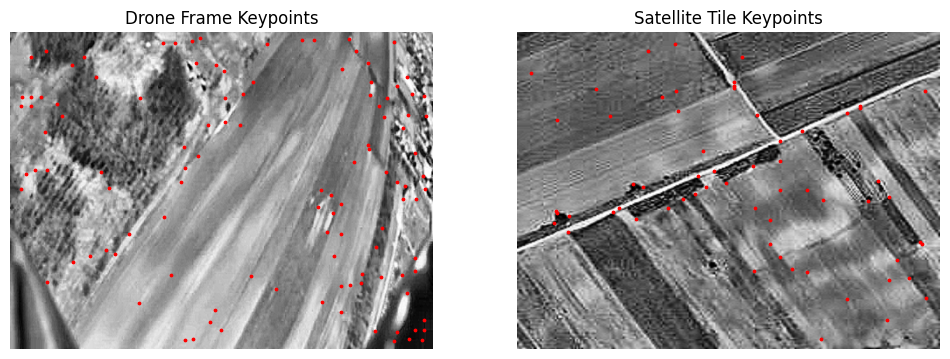

In [33]:
# Define test image paths for a frame and a satellite tile
test_frame_path = "/content/processed_frames/frame_5.pt"
test_tile_path = "/content/processed_tiles/sat_map_12.pt"

# Extract keypoints from the frame and tile images
frame_keypoints, _, _ = extract_features(test_frame_path)
tile_keypoints, _, _ = extract_features(test_tile_path)

# Check if keypoints were successfully extracted
if frame_keypoints is None or tile_keypoints is None:
    print("Error extracting keypoints from one or both images!")
else:
    # Convert keypoints to numpy arrays for visualization
    frame_keypoints = frame_keypoints.cpu().numpy()
    tile_keypoints = tile_keypoints.cpu().numpy()

    # Visualize the extracted keypoints on both images side by side
    visualize_keypoints_side_by_side(
        test_frame_path, frame_keypoints, "Drone Frame Keypoints",
        test_tile_path, tile_keypoints, "Satellite Tile Keypoints"
    )

#7: Utility Functions


##7.1. Fix Descriptor Shape


In [34]:
def fix_descriptor_shape(desc):
    """
    Ensures the descriptor tensor has the correct shape for further processing.

    Args:
        desc (torch.Tensor): The input descriptor tensor.

    Returns:
        torch.Tensor: The reshaped descriptor tensor.
    """

    # Debug: Print the original descriptor shape
    # print(f"Original descriptor shape: {desc.shape}")

    # Handle case where descriptor has an extra singleton dimension
    if desc.dim() == 4 and desc.shape[:2] == (1, 1):
        desc = desc.squeeze(1).squeeze(0)

    # If the descriptor is already in the correct shape, return as is
    if desc.dim() == 3 and desc.shape[0] == 1 and desc.shape[1] == 256:
        return desc

    # If the descriptor is 2D, add a batch dimension
    elif desc.dim() == 2:
        desc = desc.unsqueeze(0)

    # Debug: Print the fixed descriptor shape
    # print(f"Fixed descriptor shape: {desc.shape}")

    return desc

##7.2. Pad Descriptors


In [35]:
def pad_descriptors(desc, target_length):
    """
    Pads the descriptor tensor to ensure a consistent length.

    Args:
        desc (torch.Tensor): The input descriptor tensor.
        target_length (int): The desired number of keypoints.

    Returns:
        torch.Tensor: The padded descriptor tensor.
    """

    # Debug: Print the original descriptor shape
    # print(f"Original descriptor shape: {desc.shape}")

    # Ensure descriptor tensor has the correct dimensionality
    if desc.dim() == 2:
        desc = desc.permute(1, 0).unsqueeze(0)  # Convert (256, N) -> (1, 256, N)

    elif desc.dim() == 3:
        if desc.shape[0] == 256 and desc.shape[1] == 256:
            desc = desc.unsqueeze(0)  # Convert (256, 256, N) -> (1, 256, 256, N)

    elif desc.dim() == 4:
        # Handle unexpected 4D tensor shapes
        # print(f"Unexpected descriptor shape: {desc.shape}")
        desc = desc.squeeze(1).squeeze(0)  # Reduce unnecessary dimensions
        desc = desc.unsqueeze(0)  # Ensure correct shape

    else:
        raise ValueError(f"Descriptor has unexpected dimensions: {desc.shape}")

    # Ensure final descriptor shape is 3D
    if desc.dim() != 3:
        raise ValueError(f"Descriptor has incorrect dimensions after processing: {desc.shape}")

    batch, channels, num_kpts = desc.shape

    # Pad descriptors if they have fewer keypoints than target_length
    if num_kpts < target_length:
        padding = torch.zeros((batch, channels, target_length - num_kpts), device=desc.device)
        return torch.cat([desc, padding], dim=2)

    return desc

##7.3. Normalize Keypoints

In [36]:
def normalize_keypoints(kpts, image_shape):
    """
    Normalizes keypoints to be centered around zero with a scale factor.

    Args:
        kpts (torch.Tensor): Keypoints tensor of shape (N, 2).
        image_shape (tuple): Shape of the image tensor (batch, channels, height, width).

    Returns:
        torch.Tensor: Normalized keypoints.
    """

    # Extract image height and width from shape
    _, _, height, width = image_shape

    # Create a tensor with a single value of 1, matching the keypoints' device
    one = kpts.new_tensor(1)

    # Construct size tensor containing image width and height
    size = torch.stack([one * width, one * height])[None]  # Shape: (1, 2)

    # Compute center of the image
    center = size / 2  # Shape: (1, 2)

    # Compute scaling factor based on the maximum image dimension
    scaling = size.max(1, keepdim=True).values * 0.7  # Shape: (1, 1)

    # Normalize keypoints by centering and scaling
    return (kpts - center[:, None, :]) / scaling[:, None, :]

#8: Neural Network Building Blocks


##8.1. Multi-Layer Perceptron (MLP)



In [37]:
def MLP(channels: List[int], do_bn: bool = True) -> nn.Module:
    """
    Constructs a Multi-Layer Perceptron (MLP) using 1D convolutions.

    Args:
        channels (List[int]): List of channel sizes for each layer.
        do_bn (bool): Whether to include batch normalization after each convolution.

    Returns:
        nn.Module: A sequential container of the MLP layers.
    """

    n = len(channels)  # Number of layers
    layers = []

    for i in range(1, n):
        # Add a 1D convolutional layer
        layers.append(nn.Conv1d(channels[i - 1], channels[i], kernel_size=1, bias=True))

        # Apply batch normalization (except on the last layer)
        if i < (n - 1):
            if do_bn:
                layers.append(nn.BatchNorm1d(channels[i]))  # Normalizes feature maps

            layers.append(nn.ReLU())  # Apply ReLU activation function

    return nn.Sequential(*layers)  # Return the sequential model

##8.2 Multi-Headed Attention Mechanism


In [38]:
def attention(query: torch.Tensor, key: torch.Tensor, value: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Computes scaled dot-product attention.

    Args:
        query (torch.Tensor): Query tensor of shape (batch, dim, heads, num_queries).
        key (torch.Tensor): Key tensor of shape (batch, dim, heads, num_keys).
        value (torch.Tensor): Value tensor of shape (batch, dim, heads, num_keys).

    Returns:
        Tuple[torch.Tensor, torch.Tensor]:
            - The attention-weighted output tensor of shape (batch, dim, heads, num_queries).
            - The attention probabilities tensor of shape (batch, heads, num_queries, num_keys).
    """

    dim = query.shape[1]  # Extract embedding dimension

    # Compute scaled dot-product similarity scores
    scores = torch.einsum('bdhn,bdhm->bhnm', query, key) / dim**0.5

    # Apply softmax to get attention probabilities
    prob = torch.nn.functional.softmax(scores, dim=-1)

    # Compute weighted sum of values based on attention probabilities
    return torch.einsum('bhnm,bdhm->bdhn', prob, value), prob

##8.3 Keypoint Encoding


In [39]:
class KeypointEncoder(nn.Module):
    """
    Encodes keypoints and their scores into feature vectors using a Multi-Layer Perceptron (MLP).

    Args:
        feature_dim (int): Output feature dimension.
        layers (List[int]): List defining the hidden layer sizes of the MLP.

    Attributes:
        encoder (nn.Sequential): MLP network for encoding keypoints.
    """

    def __init__(self, feature_dim: int, layers: List[int]) -> None:
        super().__init__()

        # Initialize MLP with input size 3 (x, y, score) and output feature_dim
        self.encoder = MLP([3] + layers + [feature_dim])

        # Set final layer bias to zero for stability
        nn.init.constant_(self.encoder[-1].bias, 0.0)

    def forward(self, kpts: torch.Tensor, scores: torch.Tensor) -> torch.Tensor:
        """
        Forward pass to encode keypoints.

        Args:
            kpts (torch.Tensor): Keypoints of shape (batch_size, num_keypoints, 2) containing (x, y) coordinates.
            scores (torch.Tensor): Confidence scores of shape (batch_size, num_keypoints).

        Returns:
            torch.Tensor: Encoded keypoint features of shape (batch_size, feature_dim, num_keypoints).
        """

        # Prepare inputs: Transpose keypoints to match expected MLP input shape
        inputs = [kpts.transpose(1, 2), scores.unsqueeze(1)]  # Shape: [(B, 2, N), (B, 1, N)]

        # Concatenate along channel dimension and pass through the encoder
        return self.encoder(torch.cat(inputs, dim=1))  # Output shape: (B, feature_dim, N)

##8.4 Multi-Headed Self-Attention


In [40]:
class MultiHeadedAttention(nn.Module):
    """
    Implements multi-headed self-attention for feature matching.

    Args:
        num_heads (int): Number of attention heads.
        d_model (int): Total feature dimension (must be divisible by num_heads).

    Attributes:
        dim (int): Dimension of each attention head.
        num_heads (int): Number of attention heads.
        merge (nn.Conv1d): Final linear layer to merge the attention outputs.
        proj (nn.ModuleList): List of three identical projection layers for query, key, and value transformations.
    """

    def __init__(self, num_heads: int, d_model: int):
        super().__init__()

        # Ensure d_model is divisible by num_heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.dim = d_model // num_heads  # Compute dimension per head
        self.num_heads = num_heads

        # Linear projection for output merging
        self.merge = nn.Conv1d(d_model, d_model, kernel_size=1)

        # Create three identical linear projections for query, key, and value
        self.proj = nn.ModuleList([deepcopy(self.merge) for _ in range(3)])

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for multi-headed attention.

        Args:
            query (torch.Tensor): Input query tensor of shape (batch_size, d_model, num_queries).
            key (torch.Tensor): Input key tensor of shape (batch_size, d_model, num_keys).
            value (torch.Tensor): Input value tensor of shape (batch_size, d_model, num_values).

        Returns:
            torch.Tensor: Output tensor after multi-head attention, of shape (batch_size, d_model, num_queries).
        """

        batch_dim = query.size(0)

        # Apply linear projections and reshape for multi-head attention
        query, key, value = [
            l(x).view(batch_dim, self.dim, self.num_heads, -1)  # Shape: (B, dim, num_heads, N)
            for l, x in zip(self.proj, (query, key, value))
        ]

        # Compute attention mechanism
        x, _ = attention(query, key, value)

        # Reshape back and apply final merging layer
        return self.merge(x.contiguous().view(batch_dim, self.dim * self.num_heads, -1))

##8.5 Attentional Feature Propagation


In [41]:
class AttentionalPropagation(nn.Module):
    """
    Implements attentional feature propagation for matching.

    Args:
        feature_dim (int): Dimensionality of the feature space.
        num_heads (int): Number of attention heads.

    Attributes:
        attn (MultiHeadedAttention): Multi-head attention module for feature communication.
        mlp (MLP): Fully connected layers for feature transformation.
    """

    def __init__(self, feature_dim: int, num_heads: int):
        super().__init__()

        # Multi-head attention mechanism for information propagation
        self.attn = MultiHeadedAttention(num_heads, feature_dim)

        # MLP for post-attention feature transformation
        self.mlp = MLP([feature_dim * 2, feature_dim * 2, feature_dim])

        # Initialize final MLP layer bias to 0 for stable training
        nn.init.constant_(self.mlp[-1].bias, 0.0)

    def forward(self, x: torch.Tensor, source: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for attentional propagation.

        Args:
            x (torch.Tensor): Feature tensor of shape (batch_size, feature_dim, num_keypoints).
            source (torch.Tensor): Source feature tensor of shape (batch_size, feature_dim, num_keypoints).

        Returns:
            torch.Tensor: Updated feature representation after attention and transformation.
        """

        # Compute attention-based message passing
        message = self.attn(x, source, source)

        # Concatenate original features with attention-based updates and apply MLP
        return self.mlp(torch.cat([x, message], dim=1))

##8.6 Attentional Graph Neural Network (GNN)

In [42]:
class AttentionalGNN(nn.Module):
    """
    Implements an Attentional Graph Neural Network (GNN) for feature matching.

    Args:
        feature_dim (int): Dimensionality of the input feature descriptors.
        layer_names (List[str]): List of layer types indicating the order of self/cross-attention layers.

    Attributes:
        layers (nn.ModuleList): List of AttentionalPropagation layers.
        names (List[str]): Names defining self-attention or cross-attention operations.
    """

    def __init__(self, feature_dim: int, layer_names: List[str]) -> None:
        super().__init__()

        # Create multiple attention layers based on layer_names length
        self.layers = nn.ModuleList([
            AttentionalPropagation(feature_dim, 4)  # Using 4 attention heads
            for _ in range(len(layer_names))
        ])
        self.names = layer_names  # Storing the type of each layer

    def forward(self, desc0: torch.Tensor, desc1: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass for Attentional GNN.

        Args:
            desc0 (torch.Tensor): Descriptor tensor for first set of keypoints (batch_size, feature_dim, num_kpts).
            desc1 (torch.Tensor): Descriptor tensor for second set of keypoints (batch_size, feature_dim, num_kpts).

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Updated descriptors for both keypoint sets.
        """

        for layer, name in zip(self.layers, self.names):
            if name == 'cross':
                # Cross-attention: Each descriptor attends to features from the other set
                src0, src1 = desc1, desc0
            else:
                # Self-attention: Each descriptor refines itself using its own features
                src0, src1 = desc0, desc1

            # Compute feature updates using the attention mechanism
            delta0, delta1 = layer(desc0, src0), layer(desc1, src1)

            # Residual connection: Updated descriptors = original + delta
            desc0, desc1 = (desc0 + delta0), (desc1 + delta1)

        return desc0, desc1  # Return the refined descriptors

##8.8 Entropy-Regularized Optimal Transport


In [43]:
def log_sinkhorn_iterations(Z: torch.Tensor, log_mu: torch.Tensor, log_nu: torch.Tensor, iters: int) -> torch.Tensor:
    """
    Computes entropy-regularized optimal transport using log-domain Sinkhorn iterations.

    Args:
        Z (torch.Tensor): Log affinity/cost matrix (batch, num_rows, num_cols).
        log_mu (torch.Tensor): Log row marginals (batch, num_rows).
        log_nu (torch.Tensor): Log column marginals (batch, num_cols).
        iters (int): Number of iterations.

    Returns:
        torch.Tensor: Log-transport matrix.
    """

    u, v = torch.zeros_like(log_mu), torch.zeros_like(log_nu)  # Initialize dual potentials

    for _ in range(iters):
        u = log_mu - torch.logsumexp(Z + v.unsqueeze(1), dim=2)  # Normalize row-wise
        v = log_nu - torch.logsumexp(Z + u.unsqueeze(2), dim=1)  # Normalize column-wise

    return Z + u.unsqueeze(2) + v.unsqueeze(1)  # Compute transport matrix in log-space

In [44]:
def log_optimal_transport(scores: torch.Tensor, alpha: torch.Tensor, iters: int) -> torch.Tensor:
    """
    Computes log-domain entropy-regularized optimal transport.

    Args:
        scores (torch.Tensor): Log-affinity matrix (batch, num_rows, num_cols).
        alpha (torch.Tensor): Regularization parameter.
        iters (int): Number of Sinkhorn iterations.

    Returns:
        torch.Tensor: Log-transport matrix.
    """

    b, m, n = scores.shape  # Batch size, number of rows, number of cols
    one = scores.new_tensor(1)
    ms, ns = (m * one).to(scores), (n * one).to(scores)  # Convert to tensor format

    # Expand alpha to match dimensions for padding
    bins0 = alpha.expand(b, m, 1)  # Row padding
    bins1 = alpha.expand(b, 1, n)  # Column padding
    alpha = alpha.expand(b, 1, 1)  # Bottom-right padding

    # Construct extended cost matrix with additional bin rows/cols
    couplings = torch.cat([torch.cat([scores, bins0], -1),
                           torch.cat([bins1, alpha], -1)], 1)

    # Compute log-normalization constant
    norm = - (ms + ns).log()

    # Define log row and column marginals with additional bins
    log_mu = torch.cat([norm.expand(m), ns.log()[None] + norm])
    log_nu = torch.cat([norm.expand(n), ms.log()[None] + norm])

    # Expand for batch processing
    log_mu, log_nu = log_mu[None].expand(b, -1), log_nu[None].expand(b, -1)

    # Compute transport matrix using Sinkhorn iterations
    Z = log_sinkhorn_iterations(couplings, log_mu, log_nu, iters)

    # Remove normalization factor
    Z = Z - norm

    return Z

##8.9 Indexing Function

In [45]:
def arange_like(x, dim: int):
    """
    Generates a range tensor with the same device and data type as input `x`.

    Args:
        x (torch.Tensor): Input tensor to infer device and dtype.
        dim (int): Dimension along which to create the range.

    Returns:
        torch.Tensor: A tensor of indices [0, 1, ..., size-1] along the specified dimension.
    """
    return x.new_ones(x.shape[dim]).cumsum(0) - 1

# 9. SuperGlue Model


In [46]:
class SuperGlue(nn.Module):
    """
    SuperGlue is a deep learning model for feature matching between two images.
    It uses a Graph Neural Network (GNN) to refine keypoint descriptors and
    a differentiable optimal transport solver (Sinkhorn algorithm) for matching.

    Attributes:
        descriptor_dim (int): Dimensionality of descriptors (256 by default).
        weights (str): Model weights type ('outdoor' by default).
        keypoint_encoder (List[int]): MLP layers for encoding keypoints.
        GNN_layers (List[str]): Layer configuration for GNN propagation.
        sinkhorn_iterations (int): Number of iterations for Sinkhorn algorithm.
        match_threshold (float): Threshold for valid matches.

    Methods:
        forward(data): Performs feature matching between two sets of keypoints.
    """

    default_config = {
        'descriptor_dim': 256,
        'weights': 'outdoor',
        'keypoint_encoder': [32, 64, 128, 256],
        'GNN_layers': ['self', 'cross'] * 9,
        'sinkhorn_iterations': 100,
        'match_threshold': 0.5,
    }

    def __init__(self, config={}):
        """
        Initializes the SuperGlue model.

        Args:
            config (dict): Optional dictionary to override default configurations.
        """
        super().__init__()
        self.config = {**self.default_config, **config}

        # Keypoint Encoder: Embeds keypoint locations and scores into feature space.
        self.kenc = KeypointEncoder(
            self.config['descriptor_dim'], self.config['keypoint_encoder'])

        # Graph Neural Network (GNN) for feature refinement.
        self.gnn = AttentionalGNN(
            feature_dim=self.config['descriptor_dim'], layer_names=self.config['GNN_layers'])

        # Final projection layer to refine descriptors.
        self.final_proj = nn.Conv1d(
            self.config['descriptor_dim'], self.config['descriptor_dim'],
            kernel_size=1, bias=True)

        # Learnable parameter for Sinkhorn optimal transport.
        self.bin_score = nn.Parameter(torch.tensor(1.))

        # Load pre-trained weights.
        weight_path = "/content/drive/My Drive/superglue_outdoor.pth"
        self.load_state_dict(torch.load(weight_path))
        print(f'Loaded SuperGlue model (outdoor weights)')

    def forward(self, data):
        """
        Performs keypoint matching between two images.

        Args:
            data (dict): Dictionary containing:
                - 'descriptors0', 'descriptors1': Feature descriptors.
                - 'keypoints0', 'keypoints1': Keypoint coordinates.
                - 'image0', 'image1': Image tensors for shape reference.

        Returns:
            dict: Matching results containing:
                - 'matches0', 'matches1': Matched keypoint indices.
                - 'matching_scores0', 'matching_scores1': Confidence scores.
        """
        desc0, desc1 = data['descriptors0'], data['descriptors1']
        kpts0, kpts1 = data['keypoints0'], data['keypoints1']

        # Handle case where one image has no keypoints.
        if kpts0.shape[1] == 0 or kpts1.shape[1] == 0:
            shape0, shape1 = kpts0.shape[:-1], kpts1.shape[:-1]
            return {
                'matches0': kpts0.new_full(shape0, -1, dtype=torch.int),
                'matches1': kpts1.new_full(shape1, -1, dtype=torch.int),
                'matching_scores0': kpts0.new_zeros(shape0),
                'matching_scores1': kpts1.new_zeros(shape1),
            }

        # Normalize keypoints to improve matching.
        kpts0 = normalize_keypoints(kpts0, data['image0'].shape)
        kpts1 = normalize_keypoints(kpts1, data['image1'].shape)

        # Ensure descriptors have the same length by padding.
        target_kpts_length = max(desc0.shape[2], desc1.shape[2])

        desc0 = fix_descriptor_shape(desc0)
        desc1 = fix_descriptor_shape(desc1)

        desc0 = pad_descriptors(desc0, target_kpts_length)
        desc1 = pad_descriptors(desc1, target_kpts_length)

        # Apply Graph Neural Network (GNN) for descriptor refinement.
        desc0, desc1 = self.gnn(desc0, desc1)

        # Final projection of descriptors.
        mdesc0, mdesc1 = self.final_proj(desc0), self.final_proj(desc1)

        # Compute pairwise similarity scores.
        scores = torch.einsum('bdn,bdm->bnm', mdesc0, mdesc1) / self.config['descriptor_dim']**0.5

        # Compute optimal transport matrix using Sinkhorn algorithm.
        scores = log_optimal_transport(
            scores, self.bin_score,
            iters=self.config['sinkhorn_iterations'])

        # Extract matches and confidence scores.
        max0, max1 = scores[:, :-1, :-1].max(2), scores[:, :-1, :-1].max(1)
        indices0, indices1 = max0.indices, max1.indices

        # Ensure mutual agreement in matches.
        mutual0 = arange_like(indices0, 1)[None] == indices1.gather(1, indices0)
        mutual1 = arange_like(indices1, 1)[None] == indices0.gather(1, indices1)

        zero = scores.new_tensor(0)
        mscores0 = torch.where(mutual0, max0.values.exp(), zero)
        mscores1 = torch.where(mutual1, mscores0.gather(1, indices1), zero)

        valid0 = mutual0 & (mscores0 > self.config['match_threshold'])
        valid1 = mutual1 & valid0.gather(1, indices1)

        indices0 = torch.where(valid0, indices0, -1)
        indices1 = torch.where(valid1, indices1, -1)

        return {
            'matches0': indices0,
            'matches1': indices1,
            'matching_scores0': mscores0,
            'matching_scores1': mscores1,
        }

In [47]:
# Select the appropriate device: Use GPU (CUDA) if available, otherwise fallback to CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the SuperGlue model and load pretrained weights.
superglue = SuperGlue().to(device)  # Move the model to the selected device (GPU/CPU).

# Set the model to evaluation mode for inference (disables dropout, batch norm updates).
superglue.eval()

Loaded SuperGlue model (outdoor weights)


SuperGlue(
  (kenc): KeypointEncoder(
    (encoder): Sequential(
      (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
      (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
    )
  )
  (gnn): AttentionalGNN(
    (layers): ModuleList(
      (0-17): 18 x AttentionalPropagation(
        (attn): MultiHeadedAttention(
          (merge): Conv1d(256, 256, kernel_size=(1,), stride=(1

# 10. Matching Model: SuperPoint + SuperGlue

In [48]:
class Matching(torch.nn.Module):
    def __init__(self, config={}):
        super().__init__()
        # Initialize SuperPoint for keypoint detection and feature extraction.
        self.superpoint = SuperPoint(config.get('superpoint', {}))

        # Initialize SuperGlue for keypoint matching.
        self.superglue = SuperGlue(config.get('superglue', {}))

    def forward(self, data):
        pred = {}  # Dictionary to store predictions.

        # If keypoints or scores are missing for image0, detect them using SuperPoint.
        if 'keypoints0' not in data or 'scores0' not in data:
            pred0 = self.superpoint({'image': data['image0']})
            pred.update({k+'0': v for k, v in pred0.items()})  # Append keypoint data for image0.

        # If keypoints or scores are missing for image1, detect them using SuperPoint.
        if 'keypoints1' not in data or 'scores1' not in data:
            pred1 = self.superpoint({'image': data['image1']})
            pred.update({k+'1': v for k, v in pred1.items()})  # Append keypoint data for image1.

        # Merge the detected keypoints and descriptors into the input data.
        data = {**data, **pred}

        # Ensure that all values in data are stacked tensors instead of lists/tuples.
        for k in data:
            if isinstance(data[k], (list, tuple)):
                data[k] = torch.stack(data[k])

        # Check for missing scores before passing data to SuperGlue.
        if 'scores0' not in data:
            print("Error: scores0 is missing. Data keys:", data.keys())
            raise ValueError("scores0 is missing before SuperGlue.")

        # Perform keypoint matching using SuperGlue.
        pred = {**pred, **self.superglue(data)}

        return pred  # Return the final dictionary containing keypoints and matches.

In [49]:
# Check if CUDA (GPU) is available; otherwise, default to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the Matching model (which includes SuperPoint and SuperGlue)
matching = Matching().to(device)  # Move the model to the selected device (GPU or CPU)

# Set the model to evaluation mode (disables dropout, batch normalization updates, etc.)
matching.eval()

Loaded SuperPoint model
Loaded SuperGlue model (outdoor weights)


Matching(
  (superpoint): SuperPoint(
    (relu): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (convPa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (convPb): Conv2d(256, 65, kernel_size=(1, 1), stride=(1, 1))
    (convDa): Conv2d(128, 256, kernel_size=(3, 3), 

#11. Feature Loading and Preprocessing


##11.1 Function to Load Features from Disk

In [50]:
def load_features(feature_path):
    try:
        # Try to load the feature data from the given path
        data = torch.load(feature_path)
    except Exception as e:
        # In case of an error (e.g., file not found), return None for all outputs
        return None, None, None

    # Extract keypoints, descriptors, and optional scores from the loaded data
    keypoints = data.get("keypoints")
    descriptors = data.get("descriptors")
    scores = data.get("scores", None)

    # If keypoints or descriptors are missing, return None for all outputs
    if keypoints is None or descriptors is None:
        return None, None, None

    # Convert keypoints and descriptors into tensors for easier manipulation
    keypoints = torch.as_tensor(keypoints)
    descriptors = torch.as_tensor(descriptors)
    device = descriptors.device  # Track the device of descriptors (GPU or CPU)

    # If scores are provided, convert them to a tensor and move to the same device as descriptors
    if scores is not None:
        scores = torch.as_tensor(scores).to(device)

    # If descriptors have the correct shape (256), nothing needs to be done
    if descriptors.shape[1] == 256:
        pass
    elif descriptors.shape[0] == 256 and descriptors.shape[1] != 256:
        # If the descriptor shape is mismatched with keypoints, transpose the descriptors
        if keypoints.shape[0] == descriptors.shape[1]:
            descriptors = descriptors.T  # Transpose the descriptors to match keypoints count
        else:
            print(f"❌ Possible shape inconsistency in {feature_path}. Not transposing.")

    # If descriptors don't have a shape of [N, 256], print warnings
    if descriptors.shape[1] != 256:
        print(f"⚠️ Descriptor shape mismatch in {feature_path}. Fixing it carefully...")

        # If descriptors are too short or too long, print warnings about potential issues
        if descriptors.shape[1] < 256:
            print(f"❗ WARNING: Descriptors are too short ({descriptors.shape[1]}), model may fail!")
        elif descriptors.shape[1] > 256:
            print(f"❗ WARNING: Descriptors are too long ({descriptors.shape[1]}), truncation may cause errors!")

    # Return keypoints, descriptors, and scores (move everything to the device if necessary)
    return keypoints.to(device), descriptors.to(device), scores

##11.2 Loading Frame Features

In [51]:
# Initialize dictionaries to store features for frames and tiles
frame_features = {}
tile_features = {}

# List and sort all files in the 'features_folder' directory for frames
frame_files = sorted(os.listdir(features_folder))

# List and sort all files in the 'features_folder' directory for tiles
tile_files = sorted(os.listdir(features_folder))

In [52]:
# Loop through the sorted list of frame files and load features for each frame
for file in tqdm(frame_files, desc="Loading Frame Features"):
    # Check if the file name starts with "frame" and ends with ".pt" (indicating it's a feature file)
    if file.startswith("frame") and file.endswith(".pt"):
        # Construct the full file path for the frame feature file
        frame_path = os.path.join(features_folder, file)

        # Load the features for the current frame and store them in the frame_features dictionary
        frame_features[file] = load_features(frame_path)

Loading Frame Features: 100%|██████████| 111/111 [00:00<00:00, 1854.53it/s]


##11.3 Loading Tile Features

In [53]:
# Iterate through all tile feature files with a progress bar
for file in tqdm(tile_files, desc="Loading Tile Features"):

    # Check if the file is a satellite map feature file (based on naming convention)
    if file.startswith("sat_map") and file.endswith(".pt"):

        # Construct the full path to the tile feature file
        tile_path = os.path.join(features_folder, file)

        # Load the features from the file and store them in the dictionary
        tile_features[file] = load_features(tile_path)

Loading Tile Features: 100%|██████████| 111/111 [00:00<00:00, 2675.95it/s]


In [54]:
# Print the number of loaded frame and tile features for verification
print(f"Loaded {len(frame_features)} frame features and {len(tile_features)} tile features.")

Loaded 63 frame features and 48 tile features.


# 12. Feature Matching Between Frames and Tiles

##12.1 Setting Up Matching Parameters


In [55]:
# Define the target descriptor length for feature matching
TARGET_DESC_LENGTH = 256

# Set the directory to store matching results
RESULTS_DIR = "/content/match_results"

# Create the results directory if it does not exist
os.makedirs(RESULTS_DIR, exist_ok=True)

# Initialize a list to store match results
match_results_list = []

# Initialize a dictionary to store match results with keys for easy lookup
match_results = {}

##12.2 Iterating Over Frames and Tiles for Matching

In [56]:
# Iterate through each frame and its corresponding features with a progress bar
for frame_name, (frame_kpts, frame_desc, frame_scores) in tqdm(frame_features.items(), desc="Matching Frames"):

    # Skip frames that have no keypoints or descriptors
    if frame_kpts is None or frame_desc is None:
        continue

    best_match = None  # Variable to store the best-matching tile name
    best_score = -1    # Variable to store the highest matching score

    # Iterate through each tile and its corresponding features
    for tile_name, (tile_kpts, tile_desc, tile_scores) in tile_features.items():

        # Skip tiles that have no keypoints or descriptors
        if tile_kpts is None or tile_desc is None:
            continue

        # Ensure descriptors have the correct target length by padding if necessary
        frame_desc = pad_descriptors(frame_desc, TARGET_DESC_LENGTH)
        tile_desc = pad_descriptors(tile_desc, TARGET_DESC_LENGTH)

        # Prepare input data for the matching model
        data = {
            'image0': torch.zeros((1, 1, 640, 480)).to(device),  # Placeholder image tensor
            'image1': torch.zeros((1, 1, 640, 480)).to(device),  # Placeholder image tensor
            'keypoints0': frame_kpts.unsqueeze(0).to(device),  # Frame keypoints
            'keypoints1': tile_kpts.unsqueeze(0).to(device),  # Tile keypoints
            'descriptors0': frame_desc.unsqueeze(0).to(device),  # Frame descriptors
            'descriptors1': tile_desc.unsqueeze(0).to(device),  # Tile descriptors
            'scores0': frame_scores.unsqueeze(0).to(device),  # Frame keypoint scores
            'scores1': tile_scores.unsqueeze(0).to(device),  # Tile keypoint scores
        }

        # Perform feature matching without tracking gradients
        with torch.no_grad():
            pred = matching(data)

        # Extract matches and scores from the model output
        matches = pred['matches0'][0].cpu().numpy()
        scores = pred['matching_scores0'][0].cpu().numpy()

        # Identify valid matches (non-negative indices indicate valid correspondences)
        valid_matches = matches != -1
        num_matches = valid_matches.sum()  # Count the number of valid matches
        avg_score = scores[valid_matches].mean() if num_matches > 0 else 0  # Compute the average matching score

        # Store the matching result in a list for later analysis
        match_results_list.append([frame_name, tile_name, num_matches, avg_score])

        # Update the best match if the current tile has a higher average score
        if avg_score > best_score:
            best_match = tile_name
            best_score = avg_score

    # Print the best match for the current frame
    print(f"✅ Frame {frame_name} best matches with {best_match} (Score: {best_score:.2f})")

# Convert match results into a DataFrame for easy analysis
match_results_df = pd.DataFrame(match_results_list, columns=["Frame", "Tile", "Num_Matches", "Avg_Score"])

# Save the matching results as a CSV file in the results directory
match_results_csv_path = os.path.join(RESULTS_DIR, "frame_tile_matches.csv")
match_results_df.to_csv(match_results_csv_path, index=False)

# Print completion message with the saved file path
print(f"✅ Matching complete! Results saved in: {match_results_csv_path}")

Matching Frames:   2%|▏         | 1/63 [00:02<02:54,  2.82s/it]

✅ Frame frame_0.pt best matches with sat_map_20.pt (Score: 0.84)


Matching Frames:   3%|▎         | 2/63 [00:05<02:58,  2.92s/it]

✅ Frame frame_1.pt best matches with sat_map_28.pt (Score: 0.86)


Matching Frames:   5%|▍         | 3/63 [00:09<03:19,  3.32s/it]

✅ Frame frame_10.pt best matches with sat_map_00.pt (Score: 0.84)


Matching Frames:   6%|▋         | 4/63 [00:12<02:58,  3.03s/it]

✅ Frame frame_11.pt best matches with sat_map_33.pt (Score: 0.83)


Matching Frames:   8%|▊         | 5/63 [00:14<02:43,  2.81s/it]

✅ Frame frame_12.pt best matches with sat_map_47.pt (Score: 0.83)


Matching Frames:  10%|▉         | 6/63 [00:17<02:34,  2.72s/it]

✅ Frame frame_13.pt best matches with sat_map_20.pt (Score: 0.84)


Matching Frames:  11%|█         | 7/63 [00:19<02:34,  2.75s/it]

✅ Frame frame_14.pt best matches with sat_map_29.pt (Score: 0.85)


Matching Frames:  13%|█▎        | 8/63 [00:23<02:49,  3.07s/it]

✅ Frame frame_15.pt best matches with sat_map_00.pt (Score: 0.83)


Matching Frames:  14%|█▍        | 9/63 [00:26<02:44,  3.06s/it]

✅ Frame frame_16.pt best matches with sat_map_25.pt (Score: 0.82)


Matching Frames:  16%|█▌        | 10/63 [00:29<02:37,  2.98s/it]

✅ Frame frame_17.pt best matches with sat_map_00.pt (Score: 0.83)


Matching Frames:  17%|█▋        | 11/63 [00:32<02:38,  3.05s/it]

✅ Frame frame_18.pt best matches with sat_map_00.pt (Score: 0.81)


Matching Frames:  19%|█▉        | 12/63 [00:36<02:50,  3.35s/it]

✅ Frame frame_19.pt best matches with sat_map_12.pt (Score: 0.85)


Matching Frames:  21%|██        | 13/63 [00:39<02:43,  3.26s/it]

✅ Frame frame_2.pt best matches with sat_map_43.pt (Score: 0.83)


Matching Frames:  22%|██▏       | 14/63 [00:42<02:27,  3.01s/it]

✅ Frame frame_20.pt best matches with sat_map_20.pt (Score: 0.82)


Matching Frames:  24%|██▍       | 15/63 [00:45<02:20,  2.93s/it]

✅ Frame frame_21.pt best matches with sat_map_11.pt (Score: 0.83)


Matching Frames:  25%|██▌       | 16/63 [00:47<02:15,  2.88s/it]

✅ Frame frame_22.pt best matches with sat_map_11.pt (Score: 0.82)


Matching Frames:  27%|██▋       | 17/63 [00:50<02:13,  2.89s/it]

✅ Frame frame_23.pt best matches with sat_map_08.pt (Score: 0.82)


Matching Frames:  29%|██▊       | 18/63 [00:53<02:07,  2.84s/it]

✅ Frame frame_24.pt best matches with sat_map_41.pt (Score: 0.80)


Matching Frames:  30%|███       | 19/63 [00:55<01:59,  2.71s/it]

✅ Frame frame_25.pt best matches with sat_map_33.pt (Score: 0.82)


Matching Frames:  32%|███▏      | 20/63 [00:58<01:52,  2.61s/it]

✅ Frame frame_26.pt best matches with sat_map_11.pt (Score: 0.86)


Matching Frames:  33%|███▎      | 21/63 [01:01<01:56,  2.77s/it]

✅ Frame frame_27.pt best matches with sat_map_24.pt (Score: 0.83)


Matching Frames:  35%|███▍      | 22/63 [01:04<01:56,  2.84s/it]

✅ Frame frame_28.pt best matches with sat_map_24.pt (Score: 0.82)


Matching Frames:  37%|███▋      | 23/63 [01:06<01:48,  2.72s/it]

✅ Frame frame_29.pt best matches with sat_map_44.pt (Score: 0.84)


Matching Frames:  38%|███▊      | 24/63 [01:09<01:42,  2.63s/it]

✅ Frame frame_3.pt best matches with sat_map_20.pt (Score: 0.85)


Matching Frames:  40%|███▉      | 25/63 [01:11<01:37,  2.56s/it]

✅ Frame frame_30.pt best matches with sat_map_11.pt (Score: 0.83)


Matching Frames:  41%|████▏     | 26/63 [01:14<01:40,  2.71s/it]

✅ Frame frame_31.pt best matches with sat_map_11.pt (Score: 0.82)


Matching Frames:  43%|████▎     | 27/63 [01:17<01:38,  2.73s/it]

✅ Frame frame_32.pt best matches with sat_map_11.pt (Score: 0.83)


Matching Frames:  44%|████▍     | 28/63 [01:20<01:35,  2.72s/it]

✅ Frame frame_33.pt best matches with sat_map_20.pt (Score: 0.85)


Matching Frames:  46%|████▌     | 29/63 [01:22<01:32,  2.72s/it]

✅ Frame frame_34.pt best matches with sat_map_24.pt (Score: 0.84)


Matching Frames:  48%|████▊     | 30/63 [01:26<01:35,  2.90s/it]

✅ Frame frame_35.pt best matches with sat_map_44.pt (Score: 0.83)


Matching Frames:  49%|████▉     | 31/63 [01:29<01:34,  2.96s/it]

✅ Frame frame_36.pt best matches with sat_map_24.pt (Score: 0.86)


Matching Frames:  51%|█████     | 32/63 [01:31<01:26,  2.79s/it]

✅ Frame frame_37.pt best matches with sat_map_44.pt (Score: 0.86)


Matching Frames:  52%|█████▏    | 33/63 [01:34<01:23,  2.78s/it]

✅ Frame frame_38.pt best matches with sat_map_11.pt (Score: 0.85)


Matching Frames:  54%|█████▍    | 34/63 [01:37<01:20,  2.77s/it]

✅ Frame frame_39.pt best matches with sat_map_42.pt (Score: 0.83)


Matching Frames:  56%|█████▌    | 35/63 [01:40<01:18,  2.81s/it]

✅ Frame frame_4.pt best matches with sat_map_13.pt (Score: 0.84)


Matching Frames:  57%|█████▋    | 36/63 [01:43<01:21,  3.02s/it]

✅ Frame frame_40.pt best matches with sat_map_24.pt (Score: 0.84)


Matching Frames:  59%|█████▊    | 37/63 [01:46<01:13,  2.84s/it]

✅ Frame frame_41.pt best matches with sat_map_44.pt (Score: 0.86)


Matching Frames:  60%|██████    | 38/63 [01:48<01:07,  2.71s/it]

✅ Frame frame_42.pt best matches with sat_map_01.pt (Score: 0.83)


Matching Frames:  62%|██████▏   | 39/63 [01:50<01:02,  2.61s/it]

✅ Frame frame_43.pt best matches with sat_map_42.pt (Score: 0.83)


Matching Frames:  63%|██████▎   | 40/63 [01:55<01:14,  3.24s/it]

✅ Frame frame_44.pt best matches with sat_map_11.pt (Score: 0.84)


Matching Frames:  65%|██████▌   | 41/63 [01:57<01:06,  3.01s/it]

✅ Frame frame_45.pt best matches with sat_map_33.pt (Score: 0.83)


Matching Frames:  67%|██████▋   | 42/63 [02:00<00:59,  2.84s/it]

✅ Frame frame_46.pt best matches with sat_map_45.pt (Score: 0.83)


Matching Frames:  68%|██████▊   | 43/63 [02:02<00:54,  2.70s/it]

✅ Frame frame_47.pt best matches with sat_map_33.pt (Score: 0.82)


Matching Frames:  70%|██████▉   | 44/63 [02:05<00:50,  2.67s/it]

✅ Frame frame_48.pt best matches with sat_map_24.pt (Score: 0.83)


Matching Frames:  71%|███████▏  | 45/63 [02:08<00:50,  2.79s/it]

✅ Frame frame_49.pt best matches with sat_map_23.pt (Score: 0.83)


Matching Frames:  73%|███████▎  | 46/63 [02:10<00:45,  2.68s/it]

✅ Frame frame_5.pt best matches with sat_map_20.pt (Score: 0.82)


Matching Frames:  75%|███████▍  | 47/63 [02:13<00:41,  2.59s/it]

✅ Frame frame_50.pt best matches with sat_map_45.pt (Score: 0.83)


Matching Frames:  76%|███████▌  | 48/63 [02:15<00:38,  2.55s/it]

✅ Frame frame_51.pt best matches with sat_map_18.pt (Score: 0.85)


Matching Frames:  78%|███████▊  | 49/63 [02:18<00:36,  2.60s/it]

✅ Frame frame_52.pt best matches with sat_map_17.pt (Score: 0.82)


Matching Frames:  79%|███████▉  | 50/63 [02:21<00:35,  2.72s/it]

✅ Frame frame_53.pt best matches with sat_map_18.pt (Score: 0.84)


Matching Frames:  81%|████████  | 51/63 [02:23<00:31,  2.63s/it]

✅ Frame frame_54.pt best matches with sat_map_11.pt (Score: 0.82)


Matching Frames:  83%|████████▎ | 52/63 [02:26<00:28,  2.55s/it]

✅ Frame frame_55.pt best matches with sat_map_44.pt (Score: 0.84)


Matching Frames:  84%|████████▍ | 53/63 [02:28<00:25,  2.51s/it]

✅ Frame frame_56.pt best matches with sat_map_17.pt (Score: 0.83)


Matching Frames:  86%|████████▌ | 54/63 [02:31<00:23,  2.56s/it]

✅ Frame frame_57.pt best matches with sat_map_20.pt (Score: 0.84)


Matching Frames:  87%|████████▋ | 55/63 [02:34<00:21,  2.70s/it]

✅ Frame frame_58.pt best matches with sat_map_02.pt (Score: 0.83)


Matching Frames:  89%|████████▉ | 56/63 [02:36<00:18,  2.61s/it]

✅ Frame frame_59.pt best matches with sat_map_07.pt (Score: 0.83)


Matching Frames:  90%|█████████ | 57/63 [02:39<00:15,  2.56s/it]

✅ Frame frame_6.pt best matches with sat_map_11.pt (Score: 0.82)


Matching Frames:  92%|█████████▏| 58/63 [02:41<00:12,  2.52s/it]

✅ Frame frame_60.pt best matches with sat_map_20.pt (Score: 0.84)


Matching Frames:  94%|█████████▎| 59/63 [02:44<00:10,  2.59s/it]

✅ Frame frame_61.pt best matches with sat_map_20.pt (Score: 0.85)


Matching Frames:  95%|█████████▌| 60/63 [02:47<00:08,  2.70s/it]

✅ Frame frame_62.pt best matches with sat_map_20.pt (Score: 0.84)


Matching Frames:  97%|█████████▋| 61/63 [02:49<00:05,  2.61s/it]

✅ Frame frame_7.pt best matches with sat_map_43.pt (Score: 0.82)


Matching Frames:  98%|█████████▊| 62/63 [02:52<00:02,  2.55s/it]

✅ Frame frame_8.pt best matches with sat_map_20.pt (Score: 0.83)


Matching Frames: 100%|██████████| 63/63 [02:54<00:00,  2.77s/it]

✅ Frame frame_9.pt best matches with sat_map_10.pt (Score: 0.81)
✅ Matching complete! Results saved in: /content/match_results/frame_tile_matches.csv


#13. GPS Estimation from Matched Tiles


##13.1 Define File Paths for Match Results and GPS Data


In [57]:
# Path to the CSV file containing the frame-to-tile matching results
MATCH_RESULTS_PATH = "/content/match_results/frame_tile_matches.csv"

# Path to the CSV file containing GPS coordinates for the tiles
GPS_CSV_PATH = "/content/tiles/azure_csv/map.csv"

##13.2. Load GPS Data from CSV File


In [58]:
# Load the GPS data from the CSV file into a Pandas DataFrame
gps_data = pd.read_csv(GPS_CSV_PATH)

##13.3. Display Saved Match Results and GPS Data


In [59]:
# Print a message indicating that match results are being displayed
print("Saved Match Results:\n")

# Print the DataFrame containing the frame-to-tile matching results
print(match_results_df)

Saved Match Results:

           Frame           Tile  Num_Matches  Avg_Score
0     frame_0.pt  sat_map_00.pt           63   0.780238
1     frame_0.pt  sat_map_01.pt           44   0.753284
2     frame_0.pt  sat_map_02.pt           37   0.719881
3     frame_0.pt  sat_map_03.pt           14   0.690845
4     frame_0.pt  sat_map_04.pt           16   0.670112
...          ...            ...          ...        ...
3019  frame_9.pt  sat_map_43.pt           30   0.761315
3020  frame_9.pt  sat_map_44.pt           63   0.778755
3021  frame_9.pt  sat_map_45.pt           64   0.764296
3022  frame_9.pt  sat_map_46.pt           71   0.780311
3023  frame_9.pt  sat_map_47.pt           57   0.790183

[3024 rows x 4 columns]


In [60]:
print("Saved GPS Data:\n")
print(gps_data.head())

Saved GPS Data:

         Filename  Top_left_lat  Top_left_lon  Bottom_right_lat  \
0  sat_map_00.png     45.232349     20.022583         45.228481   
1  sat_map_01.png     45.232349     20.028076         45.228481   
2  sat_map_02.png     45.232349     20.033569         45.228481   
3  sat_map_03.png     45.232349     20.039062         45.228481   
4  sat_map_04.png     45.232349     20.044556         45.228481   

   Bottom_right_long  
0          20.028076  
1          20.033569  
2          20.039062  
3          20.044556  
4          20.050049  


#14. Mapping Tiles to GPS Coordinates


##14.1. Create a Dictionary to Store GPS Data for Each Tile

In [61]:
# Initialize an empty dictionary to store GPS coordinates for each tile
gps_dict = {}

# Iterate through each row in the GPS data DataFrame
for _, row in gps_data.iterrows():

    # Convert the tile image filename (PNG) to match the feature file format (PT)
    gps_dict[row['Filename'].replace('.png', '.pt')] = {
        'Top_left_lat': row['Top_left_lat'],        # Top-left latitude
        'Top_left_lon': row['Top_left_lon'],        # Top-left longitude
        'Bottom_right_lat': row['Bottom_right_lat'],  # Bottom-right latitude
        'Bottom_right_long': row['Bottom_right_long']  # Bottom-right longitude
    }

##14.2. Extract the Best Match for Each Frame


In [62]:
# Select the best match for each frame based on the highest average score
best_matches = match_results_df.loc[match_results_df.groupby("Frame")["Avg_Score"].idxmax()].reset_index(drop=True)

# Initialize a list to store estimated GPS coordinates for each frame
frame_gps_estimates = []

##14.3. Estimating Frame GPS Coordinates

In [63]:
# Iterate through the best matches to estimate frame GPS locations
for _, row in best_matches.iterrows():
    frame_name = row["Frame"]  # Extract the frame name
    tile_name = row["Tile"]  # Extract the best-matching tile name

    # Check if the tile has GPS coordinates available
    if tile_name in gps_dict:
        tile_gps = gps_dict[tile_name]  # Retrieve tile GPS data

        # Compute the estimated latitude and longitude by averaging the tile's corners
        frame_lat = (tile_gps["Top_left_lat"] + tile_gps["Bottom_right_lat"]) / 2
        frame_lon = (tile_gps["Top_left_lon"] + tile_gps["Bottom_right_long"]) / 2

        # Store the estimated GPS location for the frame
        frame_gps_estimates.append([frame_name, tile_name, frame_lat, frame_lon])

#15. Saving and Displaying GPS Estimates

In [64]:
# Convert the estimated GPS locations into a Pandas DataFrame
gps_estimates_df = pd.DataFrame(frame_gps_estimates, columns=["Frame", "Matched_Tile", "Estimated_Lat", "Estimated_Lon"])

# Define the output path for the estimated GPS coordinates
GPS_ESTIMATES_PATH = "/content/match_results/frame_gps_estimates.csv"

# Save the estimated GPS locations as a CSV file
gps_estimates_df.to_csv(GPS_ESTIMATES_PATH, index=False)

In [65]:
# Print a header for the estimated GPS locations
print("\nEstimated Frame GPS Locations:\n")

# Display the first few rows of the estimated GPS coordinates DataFrame
print(gps_estimates_df.head())

# Print a confirmation message with the file path where results are saved
print(f"\n✅ GPS estimation complete! Results saved in: {GPS_ESTIMATES_PATH}")


Estimated Frame GPS Locations:

         Frame   Matched_Tile  Estimated_Lat  Estimated_Lon
0   frame_0.pt  sat_map_20.pt      45.222678      20.047303
1   frame_1.pt  sat_map_28.pt      45.218808      20.047303
2  frame_10.pt  sat_map_00.pt      45.230415      20.025329
3  frame_11.pt  sat_map_33.pt      45.214939      20.030822
4  frame_12.pt  sat_map_47.pt      45.211069      20.063782

✅ GPS estimation complete! Results saved in: /content/match_results/frame_gps_estimates.csv


#🎯 Conclusion


This end-to-end pipeline successfully bridges the gap between drone images and satellite maps by leveraging deep learning-powered feature matching. Through the combination of SuperPoint and SuperGlue, we ensure reliable keypoint detection and matching, leading to accurate frame-to-tile associations. By incorporating GPS data, we estimate the drone's position with high precision.

This workflow is highly adaptable and can be extended to various applications, including autonomous navigation, disaster response, and environmental monitoring. Future enhancements could involve real-time processing, multi-frame fusion for trajectory estimation, and fine-tuned models for domain-specific datasets.

By automating and refining this feature-matching approach, we unlock new possibilities for geospatial intelligence and aerial mapping.